# Определение перспективного тарифа для телеком компании

В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше. Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. 
Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Исследовательский анализ данных включает в себя:

- предобработку данных
- дополненительные расчеты
- анализ факторов, влияющих на выручку
- проверка гипотезы о влиянии тарифа на среднюю выручку
- проверка гипотезы о влиянии региона на среднюю выручку


## Загрузка файлов с данными и изучение общей информации

Загрузка необходимых библиотек:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from math import ceil
import warnings
warnings.filterwarnings("ignore", category=Warning)

Загрузка таблиц:

In [2]:
calls_data = pd.read_csv('/datasets/calls.csv', parse_dates=['call_date'])
internet_data = pd.read_csv('/datasets/internet.csv', index_col=0, parse_dates=['session_date'])
messages_data = pd.read_csv('/datasets/messages.csv', parse_dates=['message_date'])
tariffs_data = pd.read_csv('/datasets/tariffs.csv')
users_data = pd.read_csv('/datasets/users.csv', parse_dates=['churn_date', 'reg_date'])

Перед предварительной обработкой и анализом данных обозначим политику Мегалайн:

«Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

### Данные о звонках

Получим общую информацию о звонках, выведем 5 верхних строк таблицы calls_data:

In [3]:
print(calls_data.info())
calls_data.head() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB
None


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


В данных обнаружены звонки с нулевой продолжительностью. Нулями обозначены пропущенные звонки, поэтому их не нужно удалять. посчитаем число таких звонков:

In [4]:
len(calls_data.query('duration == 0'))

39613

Округлим вверх продолжительность звонков:

In [5]:
calls_data['duration'] = calls_data['duration'].apply(ceil)

Посчитаем количество абонентов (пользователей) совершавших звонки:

In [6]:
len(calls_data['user_id'].unique())

492

Восемь абонентов из нашей выборки не совершали звонки.

### Данные об интернет сессиях

Получим общую информацию об интернет-сессиях абонентов, выведем 5 верхних строк таблицы internet_data:

In [7]:
print(internet_data.info())
internet_data.head() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB
None


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


Посчитаем количество абонентов совершавших интернет-сессии:

In [8]:
len(internet_data['user_id'].unique())

497

Три пользователя не пользовались интернетом. Посчитаем число сессий с объёмом использованного трафика равного 0:

In [9]:
len(internet_data.query('mb_used == 0'))

19598

В 19598 случаях Мегалайн регистрировал интернет сессии без использования трафика. Такая ситуация возможна, если устройство пользователя постояно находится в режиме передачи данных, но при этом пользователь не тратит ресурсы в активном или фоновом режиме, а интернет-сессия в Мегалайне имеет определенные временные рамки и в течении времени происходит перерегистрация в сети, без использования траффика. Следует уточнить эти данные у оператора.

### Данные о сообщениях

Получим общую информацию о сообщениях абонентов, выведем 5 верхних строк таблицы messages_data:

In [10]:
print(messages_data.info())
messages_data.head() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB
None


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Посчитаем количество абонентов отправляющих сообщения:

In [11]:
len(messages_data['user_id'].unique())

426

Сообщения самый непопулярный тип активности у абонентов из выборки: 74 абонента из 500 не пользуются сообщениями

### Данные о пользователях

Получим общую информацию о таблице users_data и выведем первые пять строк:

In [12]:
print(users_data.info())
users_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB
None


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Есть пустые знаения в столбце `churn_date`(дата прекращения пользования тарифом). Если значения пустые, то на момент выгрузки данных тариф еще действовал.

### Информация о тарифах

Выведем таблицу `tariffs_data`

In [13]:
print(tariffs_data.info())
tariffs_data 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


**Вывод:**

В нашем распоряжении данные об активности 500 абонентов Мегалайн и информация о тарифах этих пользователей. Абоненты могут использовать один из двух тарифов.

Данные о пользователях содержат пустые значения в столбце churn_date для абонентов, чей тариф активен. Всего прекративших использовать тариф абонентов - 38.

Данные о звонках, сообщениях и трафике находятся в отдельных таблицах. Согласно политике Мегалайн, данные о продолжительности звонков (в минутах) округлены вверх до целого. Обнаружены звонки с нулевой продолжительностью и интернет-сессии с нулевым трафиком. Обнаружено, что есть абоненты, которые не пользуются звонками (3 человека), интернетом (8 человек) или сообщениями (74 человека).

Для дальнейшего исследовательского анализа, необходимо оптимизировать типы данных и произвести дополнительные расчеты.

## Подготовка данных

### Приведение данных к нужным типам

Так как данные о пользователях охватывают весь 2018 год, присвоим пустым значениям в столбце `churn_date` ближайшую дату из 2019 года:

In [14]:
users_data['churn_date'] = users_data['churn_date'].fillna('2019-01-01')
users_data['churn_date'] = pd.to_datetime(users_data['churn_date']).dt.date
users_data

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,2019-01-01,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,2019-01-01,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,2019-01-01,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,2019-01-01,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,2019-01-01,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,2019-01-01,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,2019-01-01,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


Найдем максимальную продолжительность звонков:

In [15]:
calls_data['duration'].max()

38

Максимальная продолжительность звонка 38 минут, так что изменим тип данных на uint8:

In [16]:
calls_data['duration'] = calls_data['duration'].astype(np.uint8)

Найдем максимальный объем использованного интернет трафика:

In [17]:
internet_data['mb_used'].max()

1724.83

изменим тип данных на uint16:

In [18]:
internet_data['mb_used'] = internet_data['mb_used'].astype(np.uint16)

### Рассчеты и добавление результатов в таблицы

Добавим в таблицы data_calls, data_internet, data_messages дополнительный столбец с месяцем:

In [19]:
calls_data['month'] = calls_data['call_date'].dt.month
internet_data['month'] = internet_data['session_date'].dt.month
messages_data['month'] = messages_data['message_date'].dt.month

Сгруппируем данные о звонках, найдем их число и продолжительность по месяцам для каждого пользователя:

In [20]:
calls_data_grouped = calls_data.pivot_table(
    index=['user_id', 'month'], 
    values='duration',
    aggfunc=['sum', 'count']
)
calls_data_grouped.reset_index()
calls_data_grouped.columns = ['calls_duration', 'calls_amount']
calls_data_grouped

calls_duration  calls_amount
user_id month                              
1000    5               159.0            22
        6               172.0            43
        7               340.0            47
        8               408.0            52
        9               466.0            58
...                       ...           ...
1498    10              247.0            41
1499    9                70.0             9
        10              449.0            68
        11              612.0            74
        12              492.0            69

[3174 rows x 2 columns]

Сгруппируем данные об объемах использованного веб-трафика по месяцам для каждого пользователя:

In [21]:
internet_data_grouped = internet_data.pivot_table(
    index=['user_id', 'month'], 
    values='mb_used',
    aggfunc=['sum']
)
internet_data_grouped.columns = ['mb_used']
internet_data_grouped.reset_index()
internet_data_grouped

mb_used
user_id month         
1000    5         2252
        6        23213
        7        13988
        8        14043
        9        14556
...                ...
1498    10       20555
1499    9         1844
        10       17766
        11       17945
        12       13037

[3203 rows x 1 columns]

Согласно политике Мегалайна, для веб-трафика отдельные сессии не считаются, вместо этого общая сумма за месяц округляется в большую сторону. Переведём мб в гб, округляя в большую сторону:

In [22]:
def mb_to_gb(mb):
    '''Переводит мегабайты в гигабайты, округляя в большую сторону.'''
    gb = ceil(mb / 1024)
    return gb

internet_data_grouped['mb_used'] = internet_data_grouped['mb_used'].apply(mb_to_gb)
internet_data_grouped.columns = ['gb_used']
internet_data_grouped

gb_used
user_id month         
1000    5            3
        6           23
        7           14
        8           14
        9           15
...                ...
1498    10          21
1499    9            2
        10          18
        11          18
        12          13

[3203 rows x 1 columns]

Сгруппируем данные о сообщениях по месяцам для каждого пользователя:

In [23]:
messages_data_grouped = messages_data.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
messages_data_grouped.reset_index()
messages_data_grouped.columns=['messages_amount']
messages_data_grouped

messages_amount
user_id month                 
1000    5                   22
        6                   60
        7                   75
        8                   81
        9                   57
...                        ...
1498    10                  42
1499    9                   11
        10                  48
        11                  59
        12                  66

[2717 rows x 1 columns]

Объединим полученные сводные таблицы:

In [24]:
calls_internet_merged = calls_data_grouped.merge(internet_data_grouped, on=['user_id', 'month'], how='outer')
telecom_data = calls_internet_merged.merge(messages_data_grouped, on=['user_id', 'month'], how='outer')
telecom_data_pvt = telecom_data.pivot_table(index=['user_id', 'month'])
telecom_data_pvt=telecom_data_pvt.reset_index()
telecom_data_pvt

,user_id,month,calls_amount,calls_duration,gb_used,messages_amount
0,1000,5,22.0,159.0,3.0,22.0
1,1000,6,43.0,172.0,23.0,60.0
2,1000,7,47.0,340.0,14.0,75.0
3,1000,8,52.0,408.0,14.0,81.0
4,1000,9,58.0,466.0,15.0,57.0
...,...,...,...,...,...,...
3209,1498,10,41.0,247.0,21.0,42.0
3210,1499,9,9.0,70.0,2.0,11.0
3211,1499,10,68.0,449.0,18.0,48.0
3212,1499,11,74.0,612.0,18.0,59.0


Добавим в полученную таблицу информацию о городе и тарифе пользователя:

In [25]:
total_data = telecom_data_pvt.merge(users_data[['user_id','city', 'tariff']], on='user_id', how='outer').reset_index(drop=True)
total_data

,user_id,month,calls_amount,calls_duration,gb_used,messages_amount,city,tariff
0,1000,5.0,22.0,159.0,3.0,22.0,Краснодар,ultra
1,1000,6.0,43.0,172.0,23.0,60.0,Краснодар,ultra
2,1000,7.0,47.0,340.0,14.0,75.0,Краснодар,ultra
3,1000,8.0,52.0,408.0,14.0,81.0,Краснодар,ultra
4,1000,9.0,58.0,466.0,15.0,57.0,Краснодар,ultra
...,...,...,...,...,...,...,...,...
3211,1499,10.0,68.0,449.0,18.0,48.0,Пермь,smart
3212,1499,11.0,74.0,612.0,18.0,59.0,Пермь,smart
3213,1499,12.0,69.0,492.0,13.0,66.0,Пермь,smart
3214,1128,NaN,NaN,NaN,NaN,NaN,Волжский,ultra


В обзоре данных мы обнаружили, что абоненты используют не все сервисы Мегалайн, из-за этого в таблице `total_data` возникли пустые значения. Так же обнаружены два пользователя, которые не использовали ни один из сервисов. Выведем информацию о них:

In [26]:
users_data.query('user_id in [1128, 1371]')

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart


Эти абоненты пользовались тарифами непродолжительное время. Исключим их из сводной таблицы и исследования:

In [27]:
total_data = total_data.loc[:3213]

Так как пустые значения возникают в том случае, если абоненты не использовали сервисы Мегалайн (звонки, сообщения или интернет-доступ), то следовательно объем потраченных ресурсов по этим сервисам равен нулю. Основываясь на этом, заменим пустые значения на 0:

In [28]:
total_data = total_data.fillna(0)
total_data.reset_index(drop=True)

,user_id,month,calls_amount,calls_duration,gb_used,messages_amount,city,tariff
0,1000,5.0,22.0,159.0,3.0,22.0,Краснодар,ultra
1,1000,6.0,43.0,172.0,23.0,60.0,Краснодар,ultra
2,1000,7.0,47.0,340.0,14.0,75.0,Краснодар,ultra
3,1000,8.0,52.0,408.0,14.0,81.0,Краснодар,ultra
4,1000,9.0,58.0,466.0,15.0,57.0,Краснодар,ultra
...,...,...,...,...,...,...,...,...
3209,1498,10.0,41.0,247.0,21.0,42.0,Владикавказ,smart
3210,1499,9.0,9.0,70.0,2.0,11.0,Пермь,smart
3211,1499,10.0,68.0,449.0,18.0,48.0,Пермь,smart
3212,1499,11.0,74.0,612.0,18.0,59.0,Пермь,smart


Посчитаем помесячную выручку с каждого пользователя:

In [29]:
def minus_to_zero(num):
    '''Принимает и возвращает число, если число отрицательное - возвращает 0.'''
    if num < 0:
        num = 0
    return num

def margin(row):
    '''Возвращает выручку и превышения лимитов пакета, согласно тарифу.'''
    tariff = row['tariff']
    i = int(list(tariffs_data.query('tariff_name == @tariff').index)[0])
    tariff_row = tariffs_data.loc[i]
    row['calls_overrun'] = minus_to_zero(row['calls_duration'] - tariff_row['minutes_included'])
    row['gb_overrun'] = minus_to_zero(row['gb_used'] - tariff_row['mb_per_month_included']/1024)
    row['messages_overrun'] = minus_to_zero(row['messages_amount'] - tariff_row['messages_included'])
    row['cost'] = (tariff_row['rub_monthly_fee'] 
            + row['calls_overrun'] * tariff_row['rub_per_minute'] 
            + row['gb_overrun'] * tariff_row['rub_per_gb'] 
            + row['messages_overrun'] * tariff_row['rub_per_message'])    
    return row

total_data = total_data.apply(margin, axis=1)
total_data

,user_id,month,calls_amount,calls_duration,gb_used,messages_amount,city,tariff,calls_overrun,gb_overrun,messages_overrun,cost
0,1000,5.0,22.0,159.0,3.0,22.0,Краснодар,ultra,0.0,0.0,0.0,1950.0
1,1000,6.0,43.0,172.0,23.0,60.0,Краснодар,ultra,0.0,0.0,0.0,1950.0
2,1000,7.0,47.0,340.0,14.0,75.0,Краснодар,ultra,0.0,0.0,0.0,1950.0
3,1000,8.0,52.0,408.0,14.0,81.0,Краснодар,ultra,0.0,0.0,0.0,1950.0
4,1000,9.0,58.0,466.0,15.0,57.0,Краснодар,ultra,0.0,0.0,0.0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1498,10.0,41.0,247.0,21.0,42.0,Владикавказ,smart,0.0,6.0,0.0,1750.0
3210,1499,9.0,9.0,70.0,2.0,11.0,Пермь,smart,0.0,0.0,0.0,550.0
3211,1499,10.0,68.0,449.0,18.0,48.0,Пермь,smart,0.0,3.0,0.0,1150.0
3212,1499,11.0,74.0,612.0,18.0,59.0,Пермь,smart,112.0,3.0,9.0,1513.0


Оптимизируем типы данных в сводной таблице:

In [30]:
memory = total_data.memory_usage().sum()
total_data['month'] = total_data['month'].astype(np.uint8)
total_data[['calls_amount', 'calls_duration', 'gb_used','messages_amount', 
            'calls_overrun', 'gb_overrun','messages_overrun', 'cost']] = (
    total_data[['calls_amount', 'calls_duration', 'gb_used','messages_amount', 
            'calls_overrun', 'gb_overrun','messages_overrun', 'cost']].astype(np.uint16)
)
new_memory = total_data.memory_usage().sum() / memory
print('Объем памяти сводной таблицы сокращен до {:.1%}'.format(new_memory))

Объем памяти сводной таблицы сокращен до 42.7%


**Вывод:**

Столбцы с датами приведены к типу datetime, в таблице `users_data` заполнены пропущенные значения. Так как Мегалайн при расчетах использует значения, округленные до целого, данные о продолжительности звонков и объёме веб-траффика приведены к целочисленному типу. 
Данные об использовании сервисов сгруппированы для каждого абонента по месяцам, расчитана помесячная выручка. Обнаружены и исключены абоненты, не использующие сервисы Мегалайна. 
Типы данных в сводной таблице оптимизированы, что сократило объём занимаемой ейпамяти до 42.7%.

## Анализ данных

Рассмотрим поведение клиентов Мегалайн по тарифам:

In [31]:
stat = total_data.pivot_table(
    index='tariff', 
    values=['cost','calls_duration', 'gb_used', 
            'messages_amount', 'calls_overrun', 
            'gb_overrun','messages_overrun'],
    aggfunc={'cost' : [np.mean, np.std, np.var],
             'calls_duration' : [np.mean, np.std, np.var],
             'gb_used' : [np.mean, np.std, np.var], 
             'messages_amount' : [np.mean, np.std, np.var],
             'calls_overrun': np.mean, 
             'gb_overrun' : np.mean,
             'messages_overrun': np.mean}
)
stat.T

tariff                         smart          ultra
calls_duration   mean     417.934948     526.623350
                 std      190.313730     317.606098
                 var    36219.315784  100873.633397
calls_overrun    mean      41.605653       0.000000
cost             mean    1286.563930    2069.543147
                 std      816.522996     374.676411
                 var   666709.803474  140382.413025
gb_overrun       mean       2.971736       0.796954
gb_used          mean      16.308659      19.479188
                 std        5.738608       9.847301
                 var       32.931617      96.969333
messages_amount  mean      33.384029      49.363452
                 std       28.227876      47.804457
                 var      796.812958    2285.266143
messages_overrun mean       5.799910       0.000000

Средняя выручка с клиентов тарифа Смарт 1295 рублей, при абонентской плате 550 рублей, а с клиентов тарифа Ультра - 2071 рубль, при абонплате 1950 рублей. При этом абоненты тарифа Смарт в среднем превышают пакет тарифа по всем направлениям, в то время как абоненты Ультра не превышают пакет в отношении количества минут звонков и сообщений, а среднее превышение трафика по веб-трафику менее 1гб.

Разобьём сводную таблицу по тарифам:

In [32]:
smart = total_data.query('tariff == "smart"')
ultra =  total_data.query('tariff == "ultra"')

Построим диаграммы распределения суммы продолжительности звонков по месяцам, отметив на графике лимиты по тарифному пакету

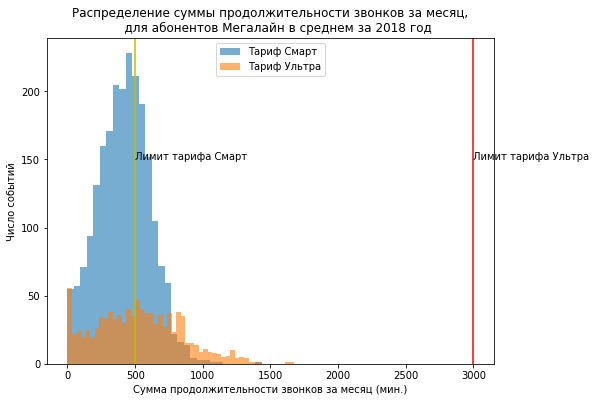

In [33]:
plt.figure(figsize=(8, 6))
plt.hist(smart['calls_duration'], bins= 30, label='Тариф Смарт', alpha = .6)
plt.hist(ultra['calls_duration'], bins= 50, label='Тариф Ультра', alpha = .6)
plt.axvline(3000, color = 'r')
plt.annotate('Лимит тарифа Ультра', xy=(3000, 150))
plt.xlabel('Сумма продолжительности звонков за месяц (мин.)')
plt.ylabel('Число событий')
plt.axvline(500, color = 'y')
plt.annotate('Лимит тарифа Смарт', xy=(500, 150))
plt.title(
    """Распределение суммы продолжительности звонков за месяц,
    для абонентов Мегалайн в среднем за 2018 год"""
)
plt.legend()
plt.show()

По гистограммам видно, что дисперсия по показателю продолжительности звонков для абонентов тарифа Смарт ниже, чем для абонентов тарифа Ультра. На гистограмме для тарифа Ультра обнаружен пик на значении 0. 

Построим диаграммы размаха:

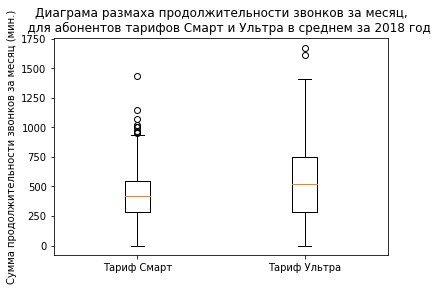

In [34]:
x1 = smart['calls_duration']
x2 = ultra['calls_duration']
plt.boxplot([x1, x2])
plt.ylabel('Сумма продолжительности звонков за месяц (мин.)')
plt.title(
    """Диаграма размаха продолжительности звонков за месяц,
    для абонентов тарифов Смарт и Ультра в среднем за 2018 год"""
)
plt.xticks([1,2], ['Тариф Смарт','Тариф Ультра'])
plt.show()

Выбросы видна диаграммах размаха для обоих тарифов, но для тарифа Смарт их число выше. Медиана для тарифа Ультра смещена в большую сторону, данные имеют положительную скошенность.

Построим диаграммы распределения объема веб-трафика по месяцам, отметив на графике лимит по тарифному пакету

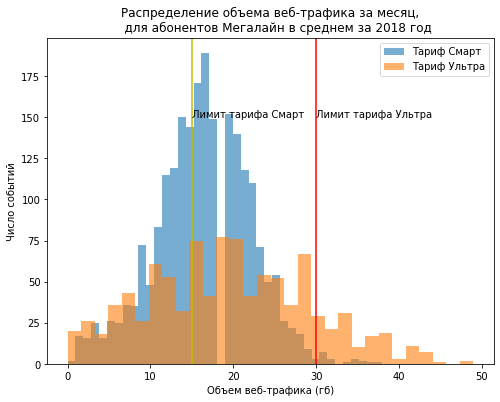

In [35]:
plt.figure(figsize=(8, 6))
plt.hist(smart['gb_used'], bins= 40, label='Тариф Смарт', alpha = .6)
plt.hist(ultra['gb_used'], bins= 30, label='Тариф Ультра', alpha = .6)
plt.xlabel('Объем веб-трафика (гб)')
plt.ylabel('Число событий')
plt.axvline(15, color = 'y')
plt.annotate('Лимит тарифа Смарт', xy=(15, 150))
plt.axvline(30, color = 'r')
plt.annotate('Лимит тарифа Ультра', xy=(30, 150))
plt.title(
    """Распределение объема веб-трафика за месяц,
    для абонентов Мегалайн в среднем за 2018 год"""
)
plt.legend()
plt.show()

По гистограммам видно, что дисперсия по показателю объёма веб-трафика для абонентов тарифа Смарт ниже, чем для абонентов тарифа Ультра. 

Построим диаграммы размаха:

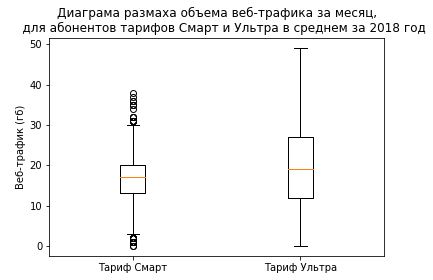

In [36]:
x1 = smart['gb_used']
x2 = ultra['gb_used']
plt.boxplot([x1, x2])
plt.ylabel('Веб-трафик (гб)')
plt.title(
    """Диаграма размаха объема веб-трафика за месяц,
    для абонентов тарифов Смарт и Ультра в среднем за 2018 год"""
)
plt.xticks([1,2], ['Тариф Смарт','Тариф Ультра'])
plt.show()

 Для этого параметра распределение данных для абонентов тарифа Ультра не имеет выбросов, в то время как для абонентов тарифа Смарт выбросы возникают с обеих сторон. Для тарифа Ультра характерна положительная скошенность данных. 

Построим диаграммы распределения числасообщений по месяцам, отметив на графике лимит по тарифному пакету

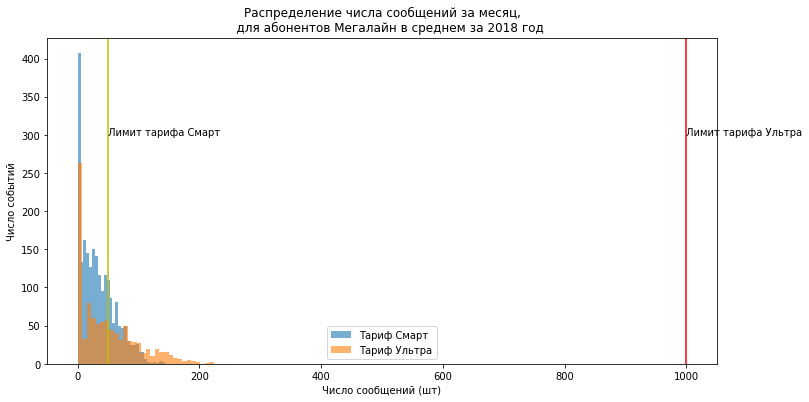

In [37]:
plt.figure(figsize=(12, 6))
plt.hist(smart['messages_amount'], bins= 30, label='Тариф Смарт', alpha = .6)
plt.hist(ultra['messages_amount'], bins= 30, label='Тариф Ультра', alpha = .6)
plt.xlabel('Число сообщений (шт)')
plt.ylabel('Число событий')
plt.axvline(50, color = 'y')
plt.annotate('Лимит тарифа Смарт', xy=(50, 300))
plt.axvline(1000, color = 'r')
plt.annotate('Лимит тарифа Ультра', xy=(1000, 300))
plt.title(
    """Распределение числа сообщений за месяц,
    для абонентов Мегалайн в среднем за 2018 год"""
)
plt.legend()
plt.show()

По гистограммам видно, что дисперсия по показателю числа сообщений для абонентов тарифа Смарт ниже, чем для абонентов тарифа Ультра. Пики в значении 0 объясняются обнаруженным нами фактом о том, что 74 человека из выборки не использовали сообщения за 2018 год.

Построим диаграмму размаха:

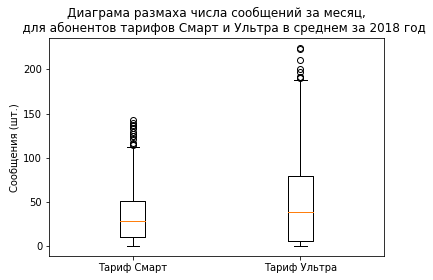

In [38]:
x1 = smart['messages_amount']
x2 = ultra['messages_amount']
plt.boxplot([x1, x2])
plt.ylabel('Сообщения (шт.)')
plt.title(
    """Диаграма размаха числа сообщений за месяц,
    для абонентов тарифов Смарт и Ультра в среднем за 2018 год"""
)
plt.xticks([1,2], ['Тариф Смарт','Тариф Ультра'])
plt.show()

Для тарифа Смарт характерно большее число выбросов, оба распределения с положительной скошенностью.

Построим диаграммы распределения выручки по месяцам сверх абонентской платы по тарифу:

In [39]:
smart['margin'] = smart['cost'] - 550
ultra['margin'] = ultra['cost'] - 1950

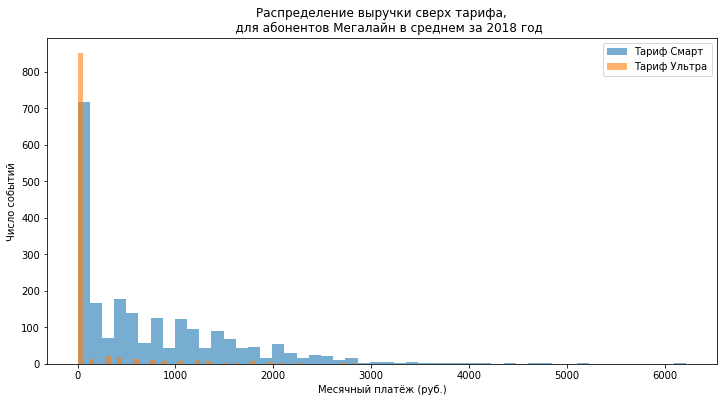

In [40]:
plt.figure(figsize=(12, 6))
plt.hist(smart['margin'], bins= 50, label='Тариф Смарт', alpha = .6)
plt.hist(ultra['margin'], bins= 50, label='Тариф Ультра', alpha = .6)
plt.xlabel('Месячный платёж (руб.)')
plt.ylabel('Число событий')
plt.title(
    """Распределение выручки сверх тарифа,
    для абонентов Мегалайн в среднем за 2018 год"""
)
plt.legend()
plt.show()

В среднем, абоненты тарифа Ультра платили за услуги связи сверх абонплаты гороздо реже, чем абоненты тарифа Смарт. При этом, в случае превышения пакета, абоненты тарифа Ультра платят за дополнительные ресурсы меньше, чем абоненты Смарт. Следовательно, если считать абонентскую плату издержками оператора, то для Магелайна выгоднее тариф Смарт.

**Вывод:**

В среднем, абоненты тарифа Ультра платили за услуги связи сверх абонплаты гороздо реже, чем абоненты тарифа Смарт. При этом, в случае превышения пакета, абоненты тарифа Ультра платят за дополнительные ресурсы меньше, чем абоненты Смарт.

Следовательно, если считать абонентскую плату издержками оператора, то для Магелайна выгоднее тариф Смарт.

Средняя выручка с клиентов тарифа Смарт 1295 рублей, при абонентской плате 550 рублей, а с клиентов тарифа Ультра - 2071 рубль, при абонплате 1950 рублей. При этом абоненты тарифа Смарт в среднем превышают пакет тарифа по всем направлениям. У абонентов тарифа Ультра к концу месяца остаются огромные остатки пакетов сообщений и минут разговора, стоит обратить на этот факт внимание и, возможно, пересмотреть лимиты тарифа для звонков и сообщений. Превышения лимита веб-трафика в среднем менее 1 гб. Вероятно, что пользователи тарифа Ультра предпочитают использовать интернет-мессенджеры.

Такие параметры как сумма минут разговора, число сообщений и объем использованного веб-трафика по тарифу Ультра имеют большую дисперсию по сравнению с тарифом Смарт, имеют положительную скошенность, медианы смещены в большую сторону.  Для тарифа Смарт характерно большее число выбросов.

Поведение пользователей тарифа Ультра имеет большую вариативность, из-за чего сложнее выделить одну моду в распределении данных. Это можно объяснить тем, что их пакет гораздо больше, чем у тарифа Смарт.

## Проверка гипотезы

### Влияние тарифа на среднюю выручку

Сформулируем нулевую гипотезу. Средняя выручка одинакова для абонентов тарифа Смарт  и Ультра.

Альтернативная гипотеза - средняя выручка для тарифа Смарт отличается от среднейвыручки для тарифа Ультра.

Мы знаем, что дисперсия наших выборок отличается. Зададим уровень критической значимости 5%. Достоверность резальтата- 95%.


In [41]:
alpha = 0.05
results = st.ttest_ind(smart['cost'], ultra['cost'], equal_var = False)
print('P-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

P-value: 8.40789217310225e-253
Отвергаем нулевую гипотезу


Вероятность случайного совпадения средних значений выручки для тарифов Смарт и Ультра ничтожно мала, следовательно нулевая гипотеза отвергается. 

**Вывод:**

Средняя выручка для тарифа Смарт отличается от среднейвыручки для тарифа Ультра

### Влияние региона абонента на среднюю выручку

Сформулируем нулевую гипотезу. Средняя выручка одинакова для абонентов из Москвы и других регионов.

Альтернативная гипотеза - средняя выручка для абонентов из Москвы отличается от среднейвыручки для для абонентов из других регионов.

Сформируем выборки по региону:

In [42]:
moscow = total_data.query('city == "Москва"')
russia =  total_data.query('~(city == "Москва")')

Посчитаем среднее и дисперсию:

In [43]:
print('Среднее значение помесячной выручки для абонентов из Москвы',np.mean(moscow['cost']))
print('Дисперсия', np.var(moscow['cost']))
print('Среднее значение помесячной выручки для абонентов не из Москвы', np.mean(russia['cost']))
print('Дисперсия', np.var(russia['cost']))

Среднее значение помесячной выручки для абонентов из Москвы 1544.504091653028
Дисперсия 564856.1190503616
Среднее значение помесячной выручки для абонентов не из Москвы 1522.3046484825202
Дисперсия 651935.9237087028


Дисперсия наших выборок отличается. Зададим уровень критической значимости 5%. Достоверность результата- 95%.

In [44]:
alpha = 0.05
results = st.ttest_ind(moscow['cost'], russia['cost'], equal_var = False)
print('P-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

P-value: 0.517656692853026
Не получилось отвергнуть нулевую гипотезу


Вероятность того, что среднее значение помесячной привыли наших выборок случайно велика, а значит не получилось отвергнуть нулевую гипотезу.

**Вывод:**

Средние значения выручки для абонентов из Москвы не отличается для абонентов из других регионов.

## Общий вывод

Был проведен исследовательский анализ данных, предоставленных оператором Мегалайн. 

В данных обнаружены звонки с нулевой продолжительностью и интернет-сессии с нулевым трафиком. Обнаружено, что в нашей выборке есть абоненты, которые в 2018 году не пользовались звонками (3 человека), интернетом (8 человек) или сообщениями (74 человека). Обнаружены и заполнены пустые значения, тип данных оптимизирован. Обнаружены и исключены 2 абонента, которые не использовали ни один из сервисов Мегалайн. Рассчитаны превышения лимита пакета в соответствии с тарифом и помесячная выручка для абонентов.

Сформулированы и проверены гипотезы о влиянии тарифа и региона на среднюю выручку. 

Средняя выручка для тарифа Смарт отличается от среднейвыручки для тарифа Ультра. 

Средняя выручка с клиентов тарифа Смарт 1295 рублей, при абонентской плате 550 рублей, а с клиентов тарифа Ультра - 2071 рубль, при абонплате 1950 рублей. При этом абоненты тарифа Смарт в среднем превышают пакет тарифа по всем направлениям. У абонентов тарифа Ультра к концу месяца остаются огромные остатки пакетов сообщений и минут разговора, стоит обратить на этот факт внимание и, возможно, пересмотреть лимиты тарифа для звонков и сообщений. Превышения лимита веб-трафика в среднем менее 1 гб.

Следовательно, если считать абонентскую плату издержками оператора, то **для Мегалайна выгоднее тариф Смарт**.

Такие параметры как сумма минут разговора, число сообщений и объем использованного веб-трафика по тарифу Ультра имеют большую дисперсию по сравнению с тарифом Смарт, имеют положительную скошенность, медианы смещены в большую сторону.  Для тарифа Смарт характерно большее число выбросов.

Поведение пользователей тарифа Ультра имеет большую вариативность, из-за чего сложнее выделить одну моду в распределении данных. Это можно объяснить тем, что их пакет гораздо больше, чем у тарифа Смарт.

Средние значения выручки для абонентов из Москвы не отличается не отличается для абонентов из других регионов.

Для нашей выборки среднее значение помесячной выручки с абонентов из Москвы 1550 рублей, среднее значение помесячной выручки с абонентов не из Москвы 1528 рублей.